In [1]:
from collections import Counter
import os
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
import torch.optim as optim
import torch
from sklearn.metrics import accuracy_score

In [2]:
from collections import Counter
import os

# Point to the training label directory
label_dir = "Road_Detection_Data/road_detection/road_detection/train/labels"

# Collect class IDs from .txt files
all_classes = []
for file in os.listdir(label_dir):
    if file.endswith('.txt'):
        with open(os.path.join(label_dir, file), 'r') as f:
            for line in f:
                class_id = line.strip().split()[0]
                all_classes.append(class_id)

# Count class frequencies
class_counts = Counter(all_classes)
class_counts = {int(k): v for k, v in class_counts.items()}


In [3]:
import torch
from torch.nn import CrossEntropyLoss

total = sum(class_counts.values())
weights = [total / class_counts[i] for i in sorted(class_counts.keys())]
weights = torch.tensor(weights, dtype=torch.float32)

loss_fn = CrossEntropyLoss(weight=weights)


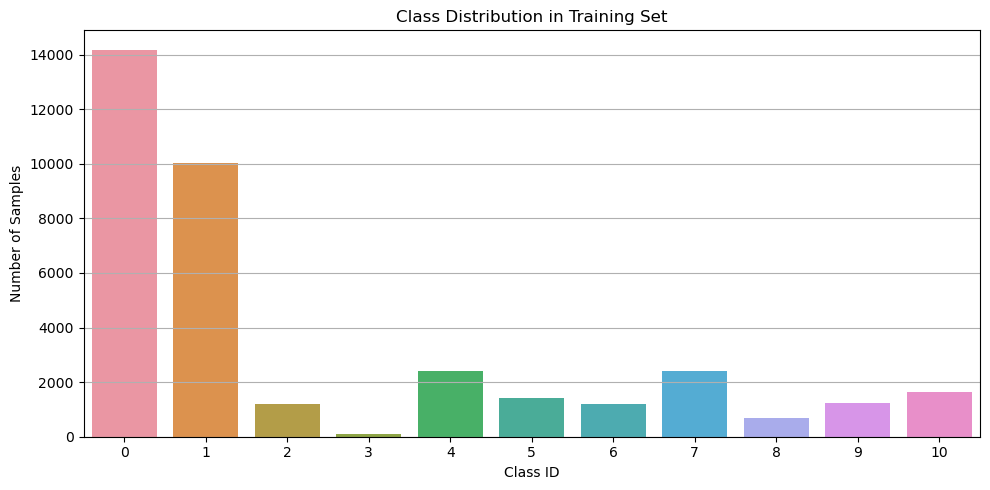

In [4]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

label_dir = "Road_Detection_Data/road_detection/road_detection/train/labels"  
all_classes = []

for file in os.listdir(label_dir):
    if file.endswith('.txt'):
        with open(os.path.join(label_dir, file), 'r') as f:
            for line in f:
                class_id = line.strip().split()[0]
                all_classes.append(class_id)

class_counts = Counter(all_classes)
class_counts = {int(k): v for k, v in class_counts.items()}

plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution in Training Set")
plt.xlabel("Class ID")
plt.ylabel("Number of Samples")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


The training dataset is imbalanced, with Class 0 and Class 1 having the most samples, while others like Class 3 and Class 8 have very few. To address this, we use weighted loss during training to help the model learn from underrepresented classes more effectively.


The goal of this transformation step is to prepare the image data for training by resizing all images to 128×128 pixels and converting them into normalized tensors. Normalization scales pixel values to the range [-1, 1], which helps the model train more efficiently and improves performance.

In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Converts image to tensor with values in [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Scales to [-1, 1]
])


In [6]:
from torch.utils.data import Dataset
from PIL import Image
import os

class RoadDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_file)
        label_path = os.path.join(self.label_dir, img_file.replace(".jpg", ".txt"))

        image = Image.open(img_path).convert("RGB")
        label = self._load_label(label_path)

        if self.transform:
            image = self.transform(image)

        return image, label

    def _load_label(self, label_path):
        with open(label_path, "r") as f:
            line = f.readline().strip()
            class_id = int(line.split()[0])  # assumes class ID is the first element
        return class_id


In [7]:
train_dataset = RoadDataset(
    image_dir="Road_Detection_Data/road_detection/road_detection/train/images",
    label_dir="Road_Detection_Data/road_detection/road_detection/train/labels",
    transform=transform  # Apply the transform here
)


In [8]:

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


This step loads a batch of training images using the DataLoader and visualized the first image along with its label. The image was unnormalized (rescaled to [0, 1]) for display. This step confirms that the dataset and labels are correctly loaded and transformed, with an image shape of [3, 128, 128] and class labels as expected.

Image batch shape: torch.Size([32, 3, 128, 128])
Label batch: tensor([9, 1, 0, 0, 9, 1, 0, 9, 0, 5, 0, 9, 4, 0, 4, 5, 6, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 4, 4, 1, 0, 0, 6])


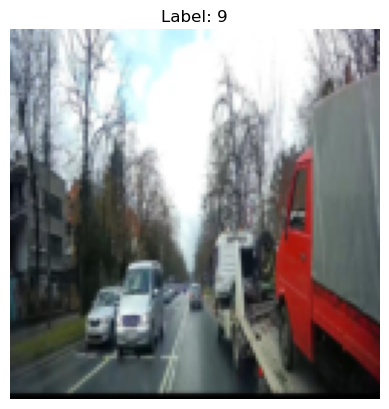

In [9]:

images, labels = next(iter(train_loader))
print("Image batch shape:", images.shape)
print("Label batch:", labels)

# Visualize the first image
plt.imshow(images[0].permute(1, 2, 0) * 0.5 + 0.5)  # unnormalize to [0,1] for display
plt.title(f"Label: {labels[0].item()}")
plt.axis('off')
plt.show()


Now we began to prepare for CNN model.

In [ ]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # Input: [3, 128, 128]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # Output: [16, 64, 64]

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # Output: [32, 32, 32]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                          # Output: [64, 16, 16]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
num_classes = len(set(train_dataset[i][1] for i in range(len(train_dataset))))
model = SimpleCNN(num_classes=num_classes)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:

loss_fn = CrossEntropyLoss(weight=weights.to(device))  # Move weights to the same device


In [ ]:


optimizer = optim.Adam(model.parameters(), lr=1e-4)


In this step, we train our convolutional neural network (CNN) using the training dataset and evaluate its performance on the validation set after each epoch. During training, the model makes predictions, calculates the loss using the cross-entropy function (with class weights to handle imbalance), and updates its parameters using the Adam optimizer. After each epoch, the model is evaluated on the validation set to monitor its generalization ability. We track the training loss and validation accuracy across epochs to understand how well the model is learning and to check for signs of underfitting or overfitting.

In [ ]:
import torch
from sklearn.metrics import accuracy_score

num_epochs = 10  # you can change this
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation step ---
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:  # <- make sure you define val_loader!
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels)

    val_acc = accuracy_score(all_labels, all_preds)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Val Accuracy: {val_acc:.4f}")
